# 3.1.2.- Implementación de un Sistema de Recomendación de películas: MovieLens


* En este Notebook vamos a implementar y evaluar un ***Sistema de Recomendación basado en Filtrado Colaborativo con KNN*** usando la base de datos de [MovieLens 100K](https://grouplens.org/datasets/movielens/).


* Esta base de datos contiene 100.000 votos con notas de 1 a 5 de 943 usuarios sobre 1682 películas.


* Este dataset ha sido dividido en votaciones de entrenamiento (80%) y votaciones de test (20%). Además para simplificar el problema, los códigos de usuarios e items, han sido modificados para que comience en 0 y terminen en el número de (usuarios / items) - 1.


* Para ***implementar y evaluar este Sistema de Recomendación*** realizaremos los siguientes paso:
<span></span><br>
    1. [Lectura del Dataset (Entrenamiento y Test)](#M1)
<span></span><br>
    2. [Cálculo de similaridades](#M2)
<span></span><br>
    3. [Cálculo de los K-Vecinos](#M3)
<span></span><br>
    4. [Cálculo de las Predicciones](#M4)
<span></span><br>
    5. [Cálculo de las recomendaciones(*)](#M5)
<span></span><br>
    6. [Evaluación del Sistema de Recomendación (MAE)](#M6)
<span></span><br>
    7. [Sistema de Recomendación y Evaluación](#M7)


##### (*): El punto del cálculo de las Recomendaciones no lo vamos a realizar ya que este punto no es relevante de cara a evaluar el sistema de recomendación implementado.


<hr>


# <a name="M1">1.- Lectura del Dataset (Entrenamiento y Test)
    
    
* A continuación implementamos una función que data la ruta donde se encuentra un fichero con la estructura "ID_USER::ID_MOVIE::RATING" nos devuelva una matriz de votos:

In [1]:
def read_ratings_matrix(file):

    ratings = [[None for _ in range(NUM_ITEMS)] for _ in range(NUM_USERS)] 
    
    with open(file, 'r') as reader:
        for line in reader:
            [u, i, rating] = line.split("::")
            ratings[int(u)][int(i)] = int(rating)
            
    return ratings

<hr>


# <a name="M2"> 2.- Cálculo de *Similaridades*


* A continuación implementamos una función que dada una matriz de votos y una métrica de similaridad, nos devuelva una matriz de similaridades entre cada par de usuarios.


* Tambien implemantamos las métricas de similaridad de:
    + MSD
    + Coseno
    + Correlación de Pearson
    + JMSD

In [2]:
def calculate_similarities(ratings_matrix, similarity_metric):
    
    # Creamos una matriz con valores de similaridad a -1
    similarities = [[float('-inf') for _ in range(NUM_USERS)] for _ in range(NUM_USERS)]
    
    # Recorremos la matriz por usuario
    for i, u in enumerate(ratings_matrix):
        if i%100==0:
            print("\tProcesandos {} Usuarios".format(i))
        for j, v in enumerate(ratings_matrix):
            if j != i: # No calculamos la similaridad para un mismo usuario
                similarities[i][j] = similarity_metric(u,v)
        
    return similarities


def rating_average(ratings):
    
    acc = 0
    count = 0
    for id_item in range(len(ratings)):
        if ratings[id_item] != None:
            acc += ratings[id_item]
            count += 1
    return acc / count


def msd_similarity(u, v):
    
    sum_r = 0 
    count = 0
    
    for i in range(len(u)):
        if u[i] != None and v[i] != None:
            count += 1
            sum_r += math.pow((u[i] - v[i])/(MAX_RATING - MIN_RATING), 2)
            
    if count > 0:
        sim = 1-(sum_r/float(count))
        return sim
    else:
        return None
    
    
def cosine_similarity(u, v):
    
    numerador = 0
    denominador_u = 0
    denominador_v = 0
    
    count = 0
    
    for i in range(len(u)):
        if u[i] != None and v[i] != None:
            numerador += u[i] * v[i]
            denominador_u += math.pow(u[i], 2)
            denominador_v += math.pow(v[i], 2)
            count += 1
    if count > 0 and denominador_u != 0 and denominador_v != 0:
        cos = numerador / (math.sqrt(denominador_u) * math.sqrt(denominador_v))
        return cos
    else:
        return None
    
    
def jmsd_similarity(u, v):
    
    union = 0
    intersection = 0
    
    for i in range(len(u)):
        if u[i] != None and v[i] != None:
            intersection += 1
            union += 1
        elif u[i] != None or v[i] != None:  
            union += 1
            
    if intersection > 0:
        jaccard = intersection / union
        return jaccard * msd_similarity(u,v)
    else:
        return None


<hr>


# <a name="M3"> 3.- Cálculo de los *K-Vecinos*
    
    
* A continuación implementamos una función que dada una matriz de similaridades entre usuarios y un valor de 'K' (número de vecinos a calcular), nos devuelva una matriz de "NUM_USERS x K_VECINOS" indicando los vecinos de cada usuario:

In [3]:
def calculate_neighbors(similarities_matrix, k_neighbors):
    
    neighbors = [None for _ in range(NUM_USERS)]
    
    for index, similarities in enumerate(similarities_matrix):
        i_neighbors = [i[0] for i in sorted(enumerate(similarities), 
                                            key=lambda x:float('-inf') if x[1] is None else x[1], 
                                            reverse=True)]
        neighbors[index] = i_neighbors[0:k_neighbors]

    return neighbors

<hr>


# <a name="M4"> 4.- Cálculo de las *Predicciones*
    
    
* A continuación implementamos un método que nos calcule las predicciones de los votos que emitirian los usuarios sobre los items con el método de agregación de "Desviación Respecto a la Media":

In [4]:
def calculate_deviation_from_mean_prediction(ratings_matrix, neighbors):
    
    # Creamos una matriz para el cálculo de predicciones
    predictions = [[None for _ in range(NUM_ITEMS)] for _ in range(NUM_USERS)]
    
    # Calculamos la media de los votos de los usuarios
    avg_user_ratings = [rating_average(user) for user in ratings_matrix]
    
    # Recorremos la matriz de votos
    for i, u in enumerate(ratings_matrix):
        for j, v in enumerate(ratings_matrix[0]):
            # Obtenemos las similaridades con cada vecino y si voto
            numerador = 0 
            denominador = 0
            for neighbor in neighbors[i]:
                if ratings_matrix[neighbor][j] != None:
                    numerador += ratings_matrix[neighbor][j] - avg_user_ratings[neighbor]
                    denominador += 1
                    
            predictions[i][j] = avg_user_ratings[i] if denominador == 0 else avg_user_ratings[i] + (numerador/denominador)
            
    return predictions

<hr>


# <a name="M6"> 6.- Evaluación del Sistema de Recomendación (MAE)
    
    
* A continuación se implementa un método que dada la matriz de votos y la matriz de predicciones nos devuelve el MAE del Sistema de Recomendación:

In [5]:
def get_mae(ratings_matrix, predictions_matrix):
    
    mae_users = [None for _ in ratings_matrix]
    
    # Recorremos la matriz de votos
    for i, u in enumerate(ratings_matrix):
        # Calculamos el MAE de cada usuario
        sum_user = 0
        count = 0
        for j, v in enumerate(ratings_matrix[0]):
            if ratings_matrix[i][j] != None and predictions_matrix[i][j] != None:
                sum_user += abs(ratings_matrix[i][j] - predictions_matrix[i][j])
                count += 1
        mae_users[i] = sum_user/count if count > 0 else None

    return np.nanmean(np.array(mae_users, dtype=np.float), axis=0)

<hr>


# <a name="M7">7.- Sistema de Recomendación y Evaluación
    
    
* A continuación se implementa el "Sistema de Recomendación", en el cual:
    + Calcularemos las similaridades para distintas métricas de similaridad
    + Realizaremos las predicciones para diferentes números de vecinos
    + Evaluaremos para cada experimento los conjuntos de entrenamiento y test.

In [6]:
import math
import numpy as np
import pandas as pd

# Número de usuarios e items
NUM_USERS = 943
NUM_ITEMS = 1682

# Notas máximas y mínimas dadas en la matriz de votos
MIN_RATING = 1
MAX_RATING = 5

# Ruta del los datasets de entrenamiento y test
TRAIN_RATINGS_FILE = '../data/movielens_100K_train_test/movielens_100k_training.txt'
TEST_RATINGS_FILE = '../data/movielens_100K_train_test/movielens_100k_test.txt'

# Lectura de los Datasets de Entrenamiento y Test
train_ratings = read_ratings_matrix(file=TRAIN_RATINGS_FILE)
test_ratings = read_ratings_matrix(file=TEST_RATINGS_FILE)

# Metricas, K vecinos y predicciones a probar
SIMILARITIES_METRICS = [('MSD', msd_similarity), 
                        ('COSENO', cosine_similarity),  
                        ('JMSD', jmsd_similarity)]
K_NEIGHBORS = [25, 50, 75, 100, 150, 200, 250, 300, 500]


# Guardo en una lista los experimentos realizados, siendo un experimento una lista con 4 posiciones:
#     1.- Métrica de similaridad
#     2.- Número de vecinos
#     3.- MAE
#     4.- Entrenamiento o Test
experiments = []

for metric in SIMILARITIES_METRICS:
    print('{}: Cálculo de similatidades'.format(metric[0]))
    similarities_matrix = calculate_similarities(ratings_matrix=train_ratings, 
                                                 similarity_metric=metric[1])
    for k in K_NEIGHBORS:
        
        print('  {} Vecinos'.format(k))
        neighbors_matrix = calculate_neighbors(k_neighbors=k, 
                                               similarities_matrix=similarities_matrix)
        
        # Calculamos las predicciones
        predictions = calculate_deviation_from_mean_prediction(ratings_matrix=train_ratings, 
                                                               neighbors=neighbors_matrix)
        
        # Calculamos el MAE para entrenamiento y test
        mae_train = get_mae(ratings_matrix=train_ratings, 
                            predictions_matrix=predictions)
        mae_test = get_mae(ratings_matrix=test_ratings, 
                            predictions_matrix=predictions)
        
        # Añadimos los experimentos a la lista
        experiments.append([metric[0], k, mae_train, "Train"])
        experiments.append([metric[0], k, mae_test, "Test"])
        

MSD: Cálculo de similatidades
	Procesandos 0 Usuarios
	Procesandos 100 Usuarios
	Procesandos 200 Usuarios
	Procesandos 300 Usuarios
	Procesandos 400 Usuarios
	Procesandos 500 Usuarios
	Procesandos 600 Usuarios
	Procesandos 700 Usuarios
	Procesandos 800 Usuarios
	Procesandos 900 Usuarios
  25 Vecinos
  50 Vecinos
  75 Vecinos
  100 Vecinos
  150 Vecinos
  200 Vecinos
  250 Vecinos
  300 Vecinos
  500 Vecinos
COSENO: Cálculo de similatidades
	Procesandos 0 Usuarios
	Procesandos 100 Usuarios
	Procesandos 200 Usuarios
	Procesandos 300 Usuarios
	Procesandos 400 Usuarios
	Procesandos 500 Usuarios
	Procesandos 600 Usuarios
	Procesandos 700 Usuarios
	Procesandos 800 Usuarios
	Procesandos 900 Usuarios
  25 Vecinos
  50 Vecinos
  75 Vecinos
  100 Vecinos
  150 Vecinos
  200 Vecinos
  250 Vecinos
  300 Vecinos
  500 Vecinos
JMSD: Cálculo de similatidades
	Procesandos 0 Usuarios
	Procesandos 100 Usuarios
	Procesandos 200 Usuarios
	Procesandos 300 Usuarios
	Procesandos 400 Usuarios
	Procesandos 500

* Pasamos los resultados de los experimentos a un DataFrame:

In [7]:
# Pasamos los resultados de los experimentos a un DataFrame
df_results = pd.DataFrame.from_records(experiments,
                                       columns=['Metrica', 'K-Vecinos', 'MAE', 'Train/Test'])


* Mostramos los resultados de los experimentos con los datos de entrenamiento:

In [8]:
pd.pivot_table(df_results[df_results['Train/Test']=='Train'], 
               values=['MAE'], 
               index=['K-Vecinos'],
               columns=['Metrica'])

MAE                    
Metrica      COSENO      JMSD       MSD
K-Vecinos                              
25         0.812634  0.745987  0.705851
50         0.792020  0.732360  0.643487
75         0.764367  0.730689  0.607786
100        0.735740  0.731017  0.589188
150        0.682711  0.733504  0.579328
200        0.644292  0.735433  0.587184
250        0.626187  0.737829  0.599432
300        0.623962  0.740431  0.612779
500        0.661807  0.747484  0.668178

* Mostramos los resultados de los experimentos con los datos de test:

In [9]:
pd.pivot_table(df_results[df_results['Train/Test']=='Test'], 
               values=['MAE'], 
               index=['K-Vecinos'],
               columns=['Metrica'])

MAE                    
Metrica      COSENO      JMSD       MSD
K-Vecinos                              
25         0.939256  0.845080  0.934870
50         0.938590  0.812128  0.911973
75         0.928684  0.801549  0.883630
100        0.914153  0.798471  0.865114
150        0.884230  0.798607  0.844284
200        0.859221  0.793671  0.827768
250        0.844865  0.794603  0.812990
300        0.831250  0.794154  0.809716
500        0.808197  0.801403  0.802831

* Pintamos los resultados

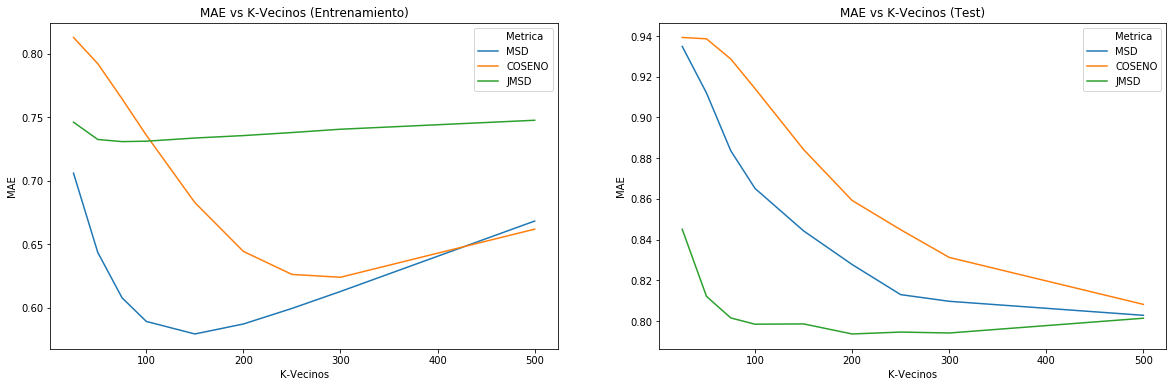

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize = (20, 6))
# Pintamos el MAE con los datos de Entrenamiento
plt.subplot(1, 2, 1)
plt.title('MAE vs K-Vecinos (Entrenamiento)')
sns.lineplot(x="K-Vecinos", y="MAE", hue="Metrica", data=df_results[df_results['Train/Test']=='Train'])

# Pintamos el MAE con los datos de Test
plt.subplot(1, 2, 2)
plt.title('MAE vs K-Vecinos (Test)')
sns.lineplot(x="K-Vecinos", y="MAE", hue="Metrica", data=df_results[df_results['Train/Test']=='Test'])

plt.show()

<hr>


*Este documento ha sido desarrollado por **Ricardo Moya**, basandose en el material creado por **Fernando Ortega**. Dpto. Sistemas Informáticos, ETSI de Sistemas Informáticos, Universidad Politécnica de Madrid.* respetando la licencia: "Atribución-NoComercial-CompartirIgual" definida por **Creative Commons Corporation**.


<img src="../imgs/CC_BY-NC-SA.png" alt="CC BY-NC">

<p style="text-align:center"><b>Atribución-NoComercial-CompartirIgual</b></p>
